<a href="https://colab.research.google.com/github/devshah21/Brain-Tumour-Classification/blob/main/brain_tumour_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devshah2021","key":"9ee02bf544ec28e077278fdc69adfb4e"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           9387        305  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           7829        191  1.0              
amaanansari09/top-100-songs                                Top 100 songs                                 6KB  2023-02-16 18:55:35           2415         76  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:2

In [7]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 99% 86.0M/86.8M [00:03<00:00, 31.3MB/s]
100% 86.8M/86.8M [00:03<00:00, 23.0MB/s]


In [ ]:
!unzip brain-tumor-classification-mri.zip

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
for dirname, _, filenames in os.walk('/content/Testing'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [24]:
label = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
#create the necessary labels to train and test this data

In [12]:
x_train, y_train = [], []
size = 150
for x in label:
  path = os.path.join('/content', 'Training', x)
  for i in tqdm(os.listdir(path)):
      img = cv2.imread(os.path.join(path,i))
      img = cv2.resize(img,(size, size))
      x_train.append(img)
      y_train.append(x)


100%|██████████| 827/827 [00:03<00:00, 212.45it/s]


In [13]:
for x in label:
  path = os.path.join('/content', 'Testing', x)
  for i in tqdm(os.listdir(path)):
      img = cv2.imread(os.path.join(path,i))
      img = cv2.resize(img,(size, size))
      x_train.append(img)
      y_train.append(x)

100%|██████████| 74/74 [00:00<00:00, 136.73it/s]


In [14]:
x_train = np.array(x_train)
y_train = np.array(y_train)

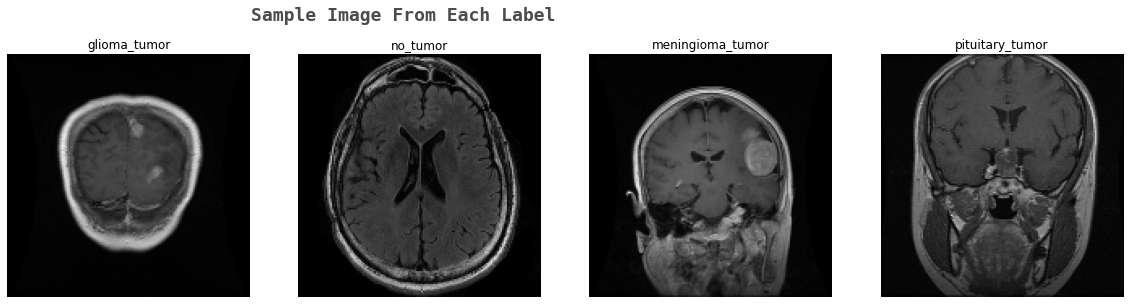

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.suptitle('Sample Image From Each Label', size=18, fontweight='bold', fontname='monospace', color= '#1F1F1F', y=0.62, x=0.4, alpha=0.8)

for i, label in enumerate(label):
    j = 0
    while True:
        if y_train[j] == label:
            ax[i].imshow(x_train[j])
            ax[i].set_title(label)
            ax[i].axis('off')
            break
        j += 1


In [16]:
x_train, y_train = shuffle(x_train,y_train, random_state=101)
#shuffling the data in x_train and y_train arrays

In [17]:
x_train.shape

(3264, 150, 150, 3)

In [19]:
x_train,X_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.1,random_state=101)
#split the data into training and testing datasets

In [ ]:
y_train_new1 = []
for i in y_train:
    y_train_new1.append(label.index(i))
y_train = y_train_new1
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new1 = []
for i in y_test:
    y_test_new1.append(label.index(i))
y_test = y_test_new1
y_test = tf.keras.utils.to_categorical(y_test)

In [43]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(size, size, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [44]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

In [45]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [47]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [48]:
#set up the callbacks
# Set up callbacks for the Keras model
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='effnet.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='auto',
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=2,
        min_delta=0.001,
        mode='auto',
        verbose=1)
]

In [49]:
results = model.fit(x_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[callbacks])

Epoch 1/12
75/75 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.6796 
Epoch 1: val_accuracy improved from -inf to 0.32830, saving model to effnet.h5
75/75 [==============================] - 1015s 13s/step - loss: 1.0499 - accuracy: 0.6796 - val_loss: 29.9631 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 2/12
75/75 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8495 
Epoch 2: val_accuracy did not improve from 0.32830
75/75 [==============================] - 942s 13s/step - loss: 0.4208 - accuracy: 0.8495 - val_loss: 5.8253 - val_accuracy: 0.2038 - lr: 0.0010
Epoch 3/12
75/75 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9319 
Epoch 3: val_accuracy improved from 0.32830 to 0.72075, saving model to effnet.h5
75/75 [==============================] - 928s 12s/step - loss: 0.2067 - accuracy: 0.9319 - val_loss: 1.0932 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 4/12
75/75 [==============================] - ETA: 0s - loss: 0

In [54]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

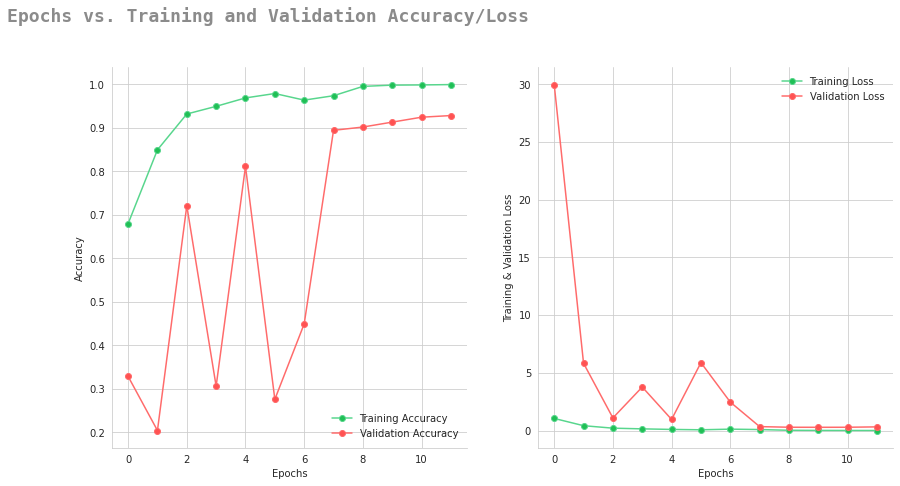

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
colors_dark = ['#3E3E3E', '#6E6E6E', '#9E9E9E']
colors_green = ['#1DB954', '#1ED760', '#20BF55', '#58D68D']
colors_red = ['#FF0040', '#FF4136', '#FF5252', '#FF6B6B']

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# define epochs
epochs = [i for i in range(12)]

# create subplots
fig, ax = plt.subplots(1, 2, figsize=(14,7))

# get training and validation accuracy/loss
train_acc = results.history['accuracy']
train_loss = results.history['loss']
val_acc = results.history['val_accuracy']
val_loss = results.history['val_loss']

# set title for figure
fig.suptitle('Epochs vs. Training and Validation Accuracy/Loss', fontsize=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

# plot training and validation accuracy
sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# plot training and validation loss
sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

# show figure
plt.show()


In [52]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new1 = np.argmax(y_test,axis=1)

10/10 [==============================] - 28s 2s/step


In [89]:
model.save('brain_tumour.h5') 

In [53]:
print(classification_report(y_test_new1,pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.98      0.98      0.98        46
           2       0.98      0.92      0.95        90
           3       0.98      0.99      0.98        85

    accuracy                           0.96       294
   macro avg       0.96      0.97      0.96       294
weighted avg       0.96      0.96      0.96       294



In [82]:
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'No Tumor'
    elif num==2:
        return 'Meningioma Tumor'
    else:
        return 'Pituitary Tumor'

1/1 [==============================] - 0s 140ms/step


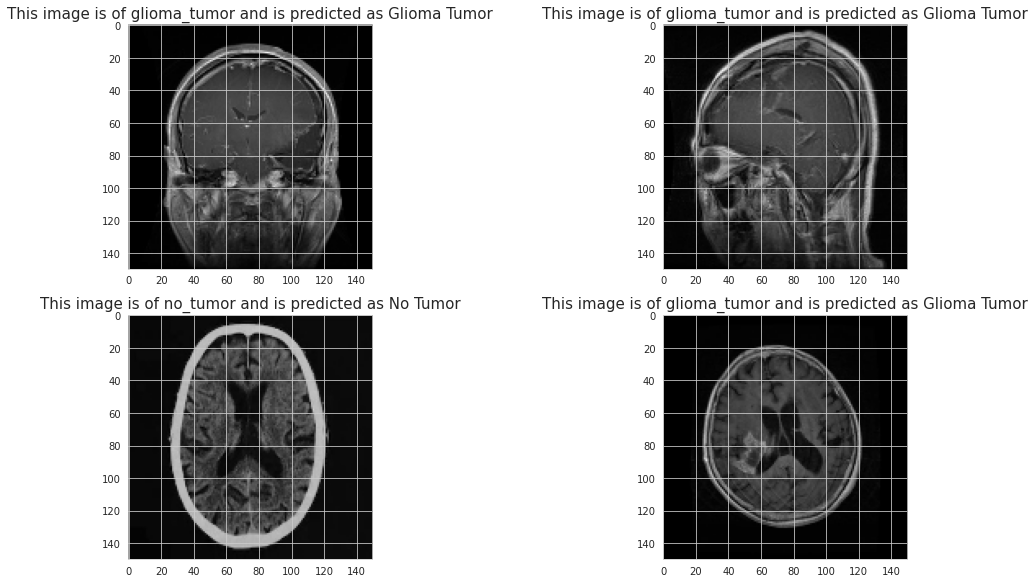

In [83]:
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(len(X_test))
    pred_class=inverse_classes(np.argmax(model.predict(np.reshape(X_test[index],(-1,150,150,3))),axis=1))
    true_label = label[np.argmax(y_test[index])]
    plt.title('This image is of {0} and is predicted as {1}'.format(true_label, pred_class),
              fontdict={'size':15})
    plt.imshow(X_test[index])
    plt.tight_layout()


In [84]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [85]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [86]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])